## Olivetti Faces — Unsupervised and Semi-Supervised Learning (Chapter 8)

### 1️⃣Overview

In this notebook, I study and apply the concepts from **Chapter 8: Unsupervised Learning Techniques** of *Hands-On Machine Learning with Scikit-Learn and PyTorch*, using the **Olivetti Faces dataset** as a unified experimental setting.

The notebook is built around **Exercises 10–13** from the end of the chapter and is structured as a small, self-contained project rather than a collection of isolated experiments. The goal is to move beyond theoretical descriptions and develop a practical, implementation-oriented understanding of unsupervised and semi-supervised learning methods.

---

### What This Project Is About

This project explores how unsupervised learning techniques can be used to:

- Discover structure in high-dimensional image data
- Learn useful representations without explicit labels
- Improve supervised learning through feature transformation
- Model data distributions for generation and anomaly detection

All experiments are conducted on the same dataset to ensure consistency and to highlight how different techniques complement each other.

---

### Chapter and Exercises Covered

This notebook focuses on the following parts of **Chapter 8**:

- Clustering algorithms (with emphasis on k-means)
- Dimensionality reduction techniques
- Gaussian Mixture Models
- Anomaly and novelty detection

Specifically, it implements and analyzes **Exercises 10–13** from the chapter.

---

### What Will Be Demonstrated

The notebook demonstrates the following concepts in practice:

- **Clustering**
  - k-means clustering on high-dimensional face images
  - Choosing the number of clusters using inertia and silhouette score
  - Visual inspection of cluster contents

- **Dimensionality Reduction**
  - Using k-means as a feature transformation method
  - Applying PCA to reduce dimensionality while preserving variance

- **Gaussian Mixture Models**
  - Training GMMs in reduced-dimensional space
  - Generating new face-like images
  - Using probabilistic density estimates

- **Anomaly Detection**
  - Detecting anomalies using GMM likelihood scores
  - Detecting anomalies using PCA reconstruction error
  - Comparing normal and artificially modified images

---

### Goal of This Notebook

The goal of this notebook is to demonstrate a **clear, end-to-end understanding** of unsupervised learning techniques by combining theory, implementation, and empirical evaluation, in a form suitable for a professional machine learning portfolio

### 2️⃣ Imports + Global Configuration

In [3]:
import sys

assert sys.version_info >= (3, 10) 

from packaging.version import Version
import sklearn

assert Version(sklearn.__version__) >= Version("1.6.1")

In [35]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.datasets import fetch_olivetti_faces


from sklearn.cluster import (
    KMeans,
    MiniBatchKMeans,
    DBSCAN,
    MeanShift,
    estimate_bandwidth,
    Birch
)

from sklearn.mixture import (
    GaussianMixture,
    BayesianGaussianMixture
)


from sklearn.decomposition import PCA

from sklearn.metrics import (
    silhouette_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix,
    classification_report
)

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.linear_model import LogisticRegression

from sklearn.semi_supervised import (
    LabelPropagation,
    LabelSpreading
)

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score, 
    StratifiedShuffleSplit
)

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [5]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### 3️⃣ Load the Dataset

In [11]:
olivetti = fetch_olivetti_faces(shuffle=True, random_state=RANDOM_STATE)

In [9]:
print(olivetti.DESCR) 

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

In [15]:
X = olivetti.data
images = olivetti.images
y = olivetti.target # Person IDs 40 classes

print("X shapes: number_of_samples, number_of_features", X.shape) 
print("Image shapes:", images.shape)
print("y shapes:", y.shape)
print("Number of unique classes", len(np.unique(y)))

X shapes: number_of_samples, number_of_features (400, 4096)
Image shapes: (400, 64, 64)
y shapes: (400,)
Number of unique classes 40


In [16]:
olivetti.target

array([20, 28,  3, 21,  9,  8, 32,  9, 26, 12,  0, 36,  5,  7, 13,  4, 27,
       37, 23, 38,  7,  1, 39, 27,  0, 39, 11, 22, 26, 10, 39, 19, 26,  5,
       23, 11, 11, 34, 15, 14, 38,  5,  7,  2,  8, 38, 14, 18,  2, 17,  4,
       32, 33,  7, 37,  3, 22, 17,  3, 15, 12, 29, 25,  7, 10,  3, 35, 26,
       39,  7, 32, 14,  0,  4, 38, 24, 22, 36, 17, 28,  0,  1, 20, 25, 27,
        6, 24, 30, 10,  9, 23, 33, 11, 22, 18, 31, 37, 38, 23,  7, 24, 11,
        1,  6, 15,  0,  1, 13, 35, 34, 13, 38, 29, 38, 29,  6,  7, 28, 30,
       28, 15, 10,  1, 34,  2, 17, 35, 33, 16, 24, 31, 14, 25, 17, 11, 19,
       22, 26, 21, 30,  3, 13, 29, 15, 19, 28,  5, 11, 16, 36,  0, 33, 27,
       15,  1, 19, 10,  8, 31, 39, 37, 20, 28, 16, 35,  8, 37, 16, 14, 22,
        9,  6, 12,  9, 14, 32,  9, 23,  6,  2,  3, 14, 12, 18,  6, 19, 32,
       21, 31, 19, 12, 14, 37,  8, 33, 34, 33, 35, 33, 30, 18, 20, 28, 21,
       28, 12,  3,  1, 32, 18, 22, 11, 17, 32, 29, 11, 36, 27, 38, 28, 36,
       16, 25, 13, 15, 19

### 4️⃣ Train / Validation / Test Split (Stratified)

In [23]:
# 60% train 20% validation 20% test

# Why sStratifiedShuffleSplit => Each split keeps the same class proportions as the full dataset
# Wy split in two splits => Because train_test_split can only split into two parts

# We have X data for ML, images 64x64, for visualization, y labels (person ID), all the represent same sample but in differnt forms
#   => So we split all three together keeping alignment 

# Example why do we solit into three parts: study using practise problems - TRAINING, take mock exam - VALIDATION, real exam - TEST
# The validation set: is not used to fit parameters but is used to compare models

X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(
    X, y, images,
    test_size=0.4, 
    stratify=y, 
    random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test, images_val, images_test = train_test_split(
    X_temp, y_temp, images_temp,
    test_size=0.4, 
    stratify=y_temp, 
    random_state=RANDOM_STATE
)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (240, 4096) (240,)
Val: (96, 4096) (96,)
Test: (64, 4096) (64,)


In [21]:
def class_counts(y_split): 
    counts = Counter(y_split) 
    return min(counts.values()), max(counts.values())

print("Train:", class_counts(y_train))
print("Val:  ", class_counts(y_val))
print("Test: ", class_counts(y_test))

# Counter counts how many times each class appears in this case in y_train

Train: (6, 6)
Val:   (2, 3)
Test:  (1, 2)


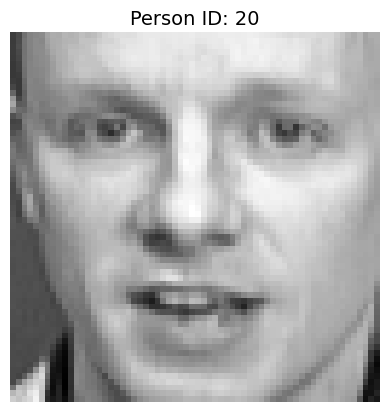

In [25]:
plt.figure()
plt.imshow(images[0], cmap="gray")
plt.title(f"Person ID: {y[0]}")
plt.axis("off")
plt.show()

### Step 5️⃣ Choose the Number of Clusters (k)

In [37]:
# Inertia = sum of squared distances from points to their assigned centroid
#   We look for an elbow point where improvement slows down
# Silhouette Score = measures how well points fit within their cluster vs other clusters
#   range[-1, 1], close to 1 -> well separated, close to 0 overlapping clusters, negative wrond assingments


k_values = range(10, 121, 10)

inertias = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(
        n_clusters=k, 
        random_state=RANDOM_STATE, 
        n_init=10
        ) 
    
    labels = kmeans.fit_predict(X_train)

    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_train, labels)) 

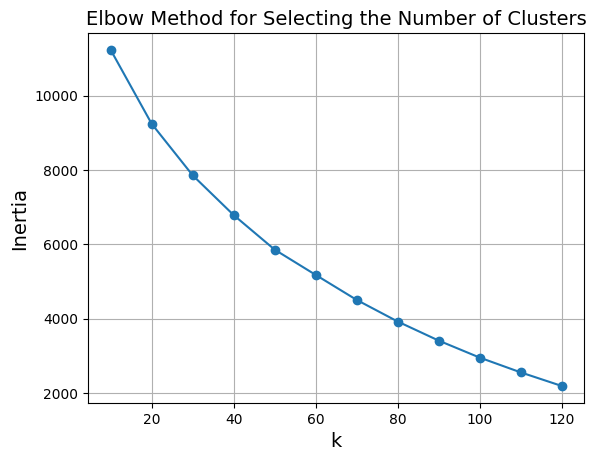

In [38]:
# Plot 1 Elbow Method 
plt.figure() 
plt.plot(k_values, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method for Selecting the Number of Clusters")
plt.grid(True)
plt.show() 

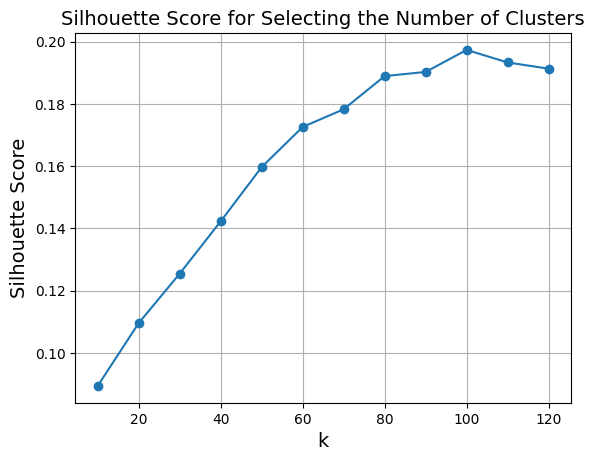

In [40]:
# Plot Silhouette Score

plt.figure() 
plt.plot(k_values, silhouette_scores, marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette Score") 
plt.title("Silhouette Score for Selecting the Number of Clusters")
plt.grid(True)
plt.show() 

Based on the elbow plot, inertia shows diminishing returns beyond approximately k = 80

The silhouette score increases up to around k = 100 and then stabilizes

Therefore k = 80 or k = 100 represents a reasonable trade-off between compactness and separation and is chosen for subsequent experiments 

### Step 7️⃣ Visualize Clusters

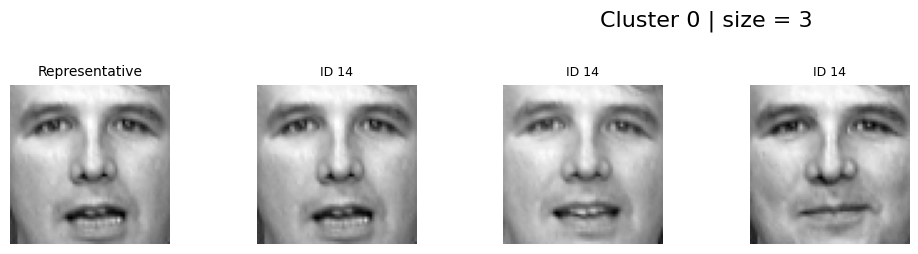

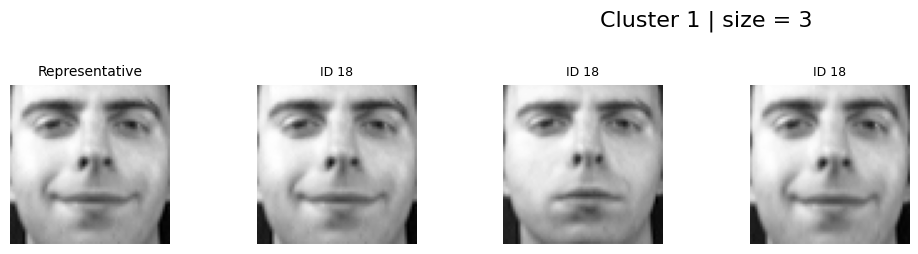

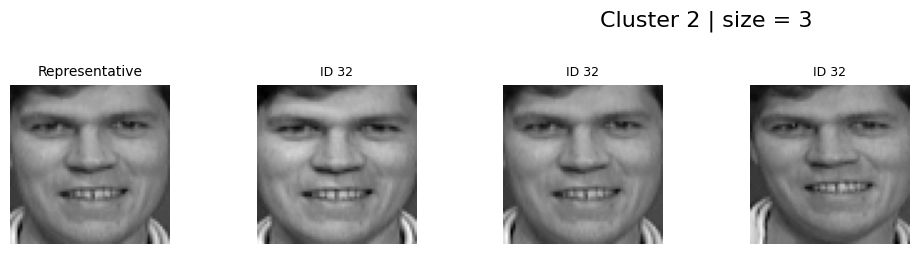

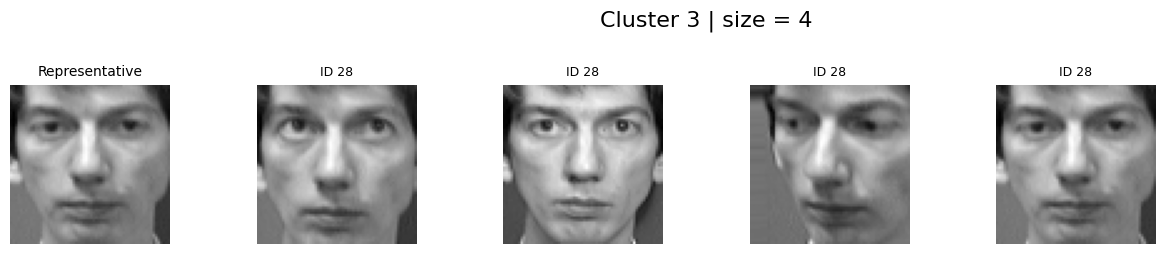

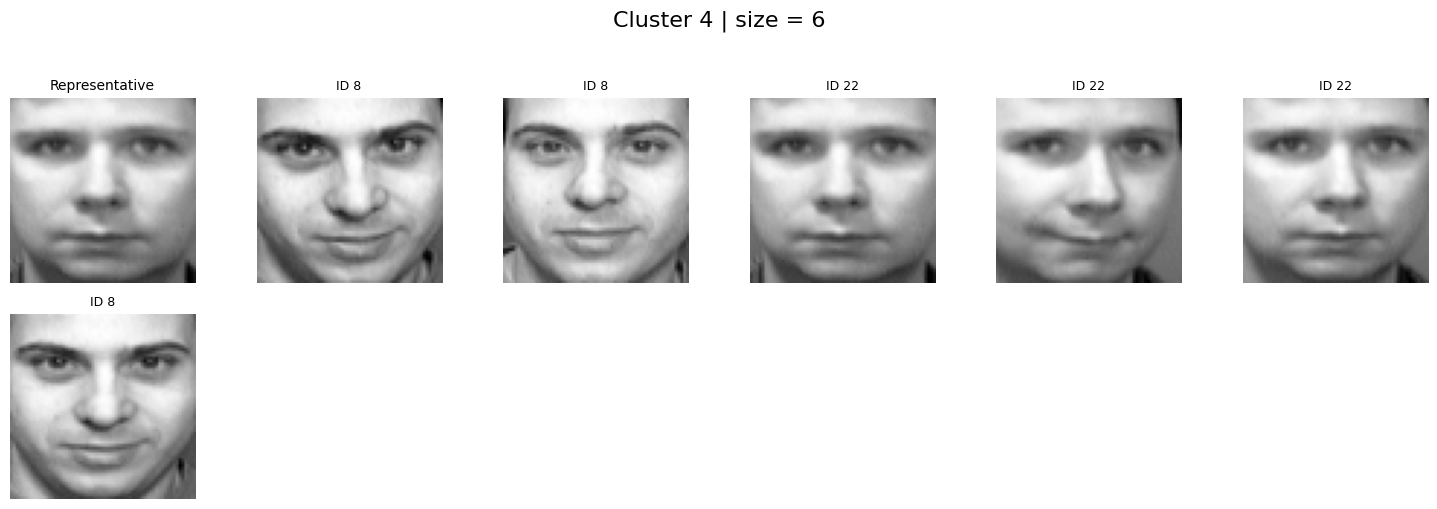

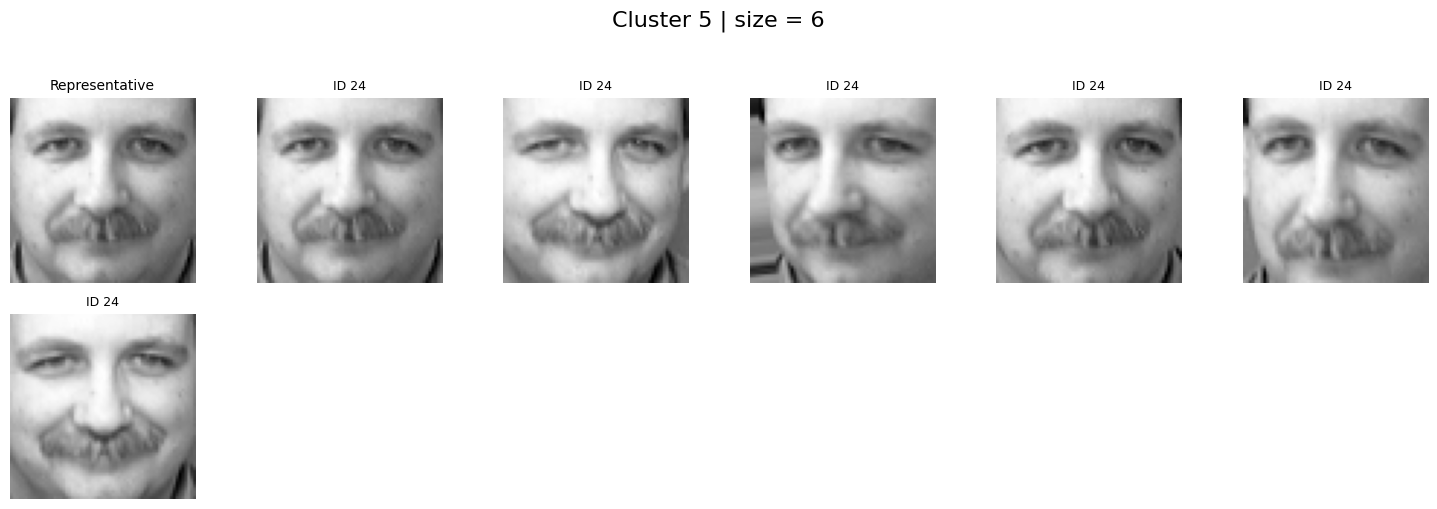

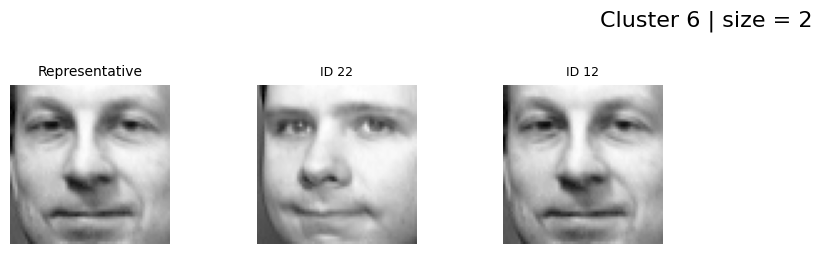

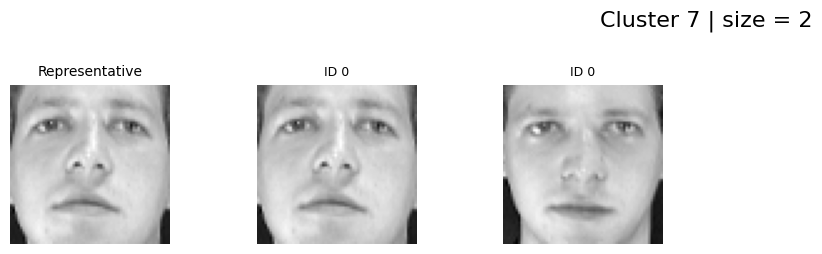

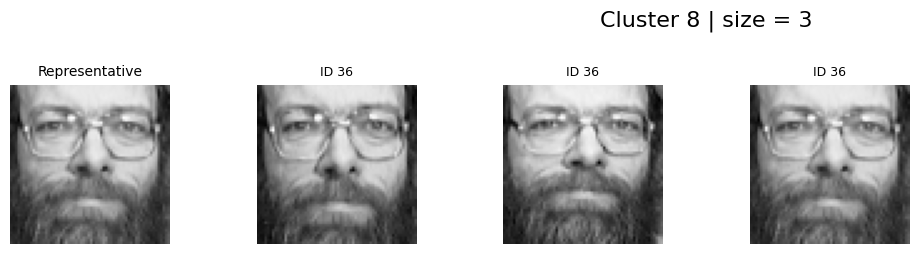

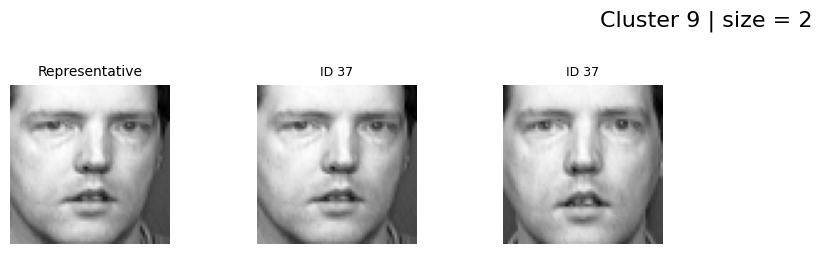

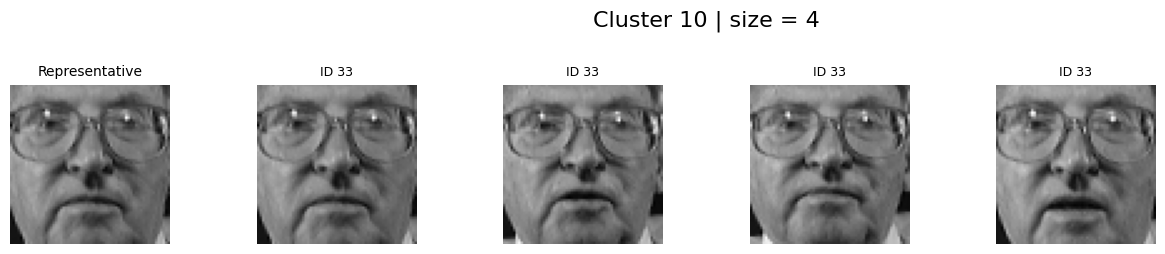

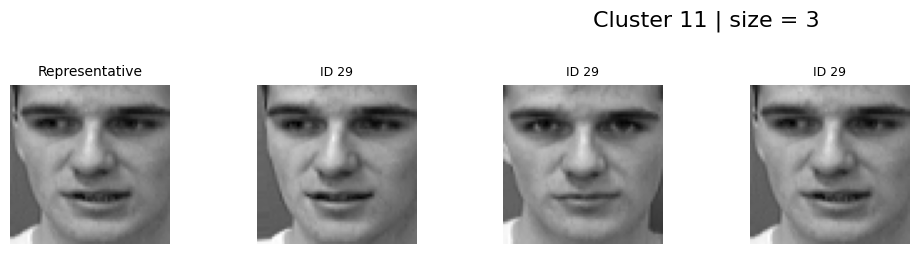

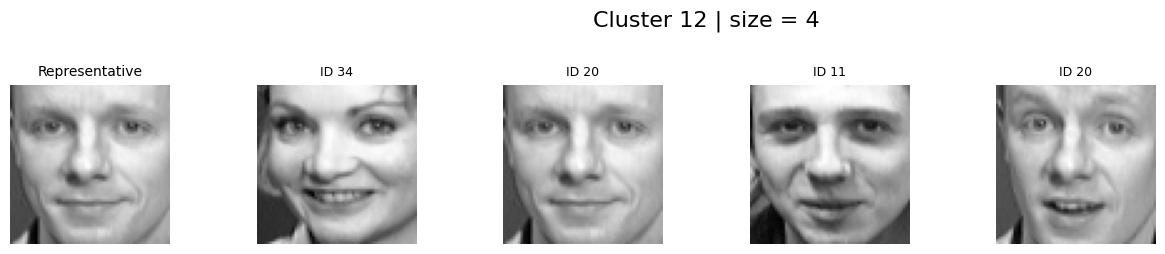

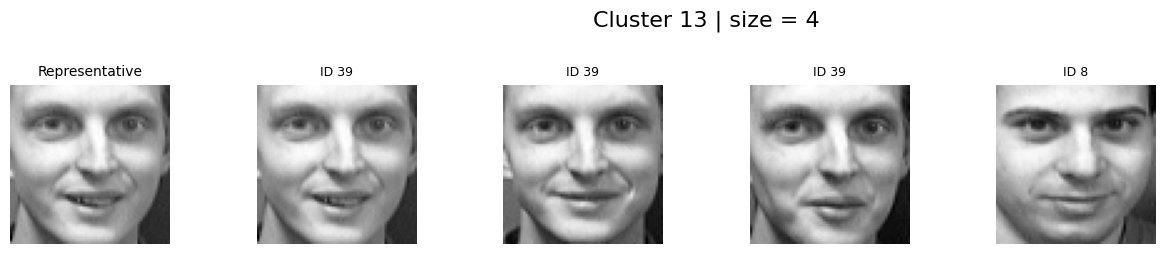

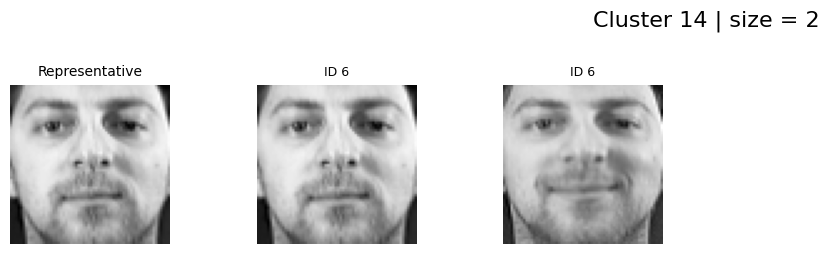

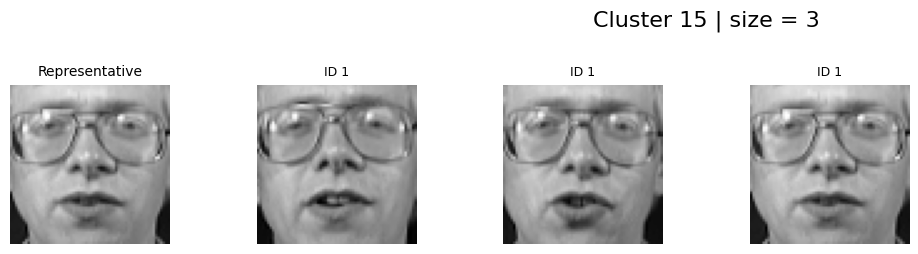

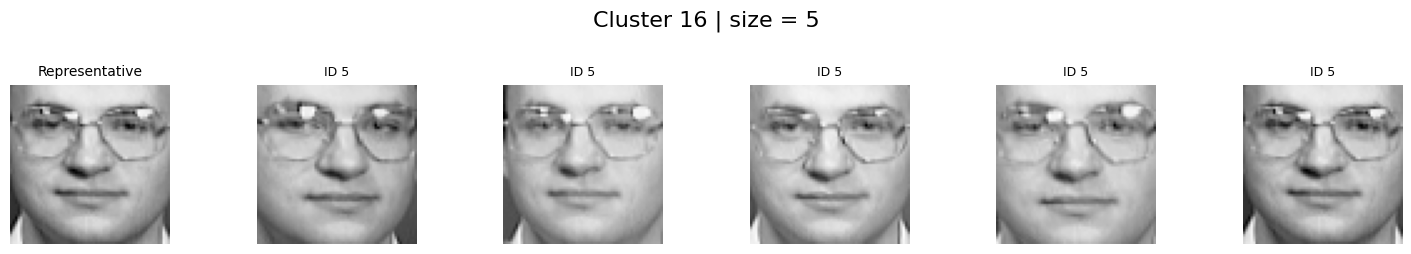

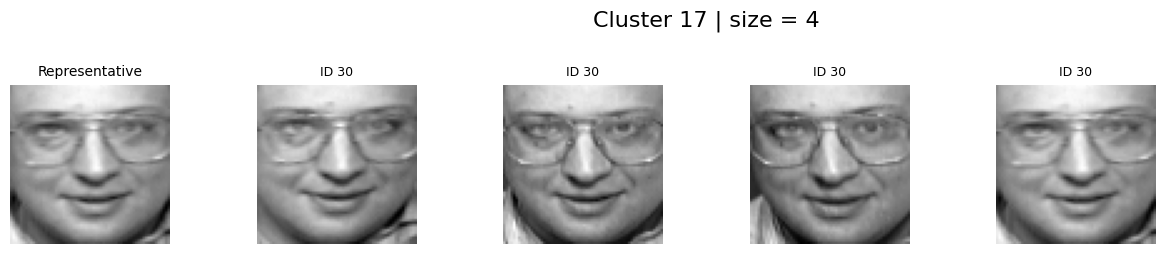

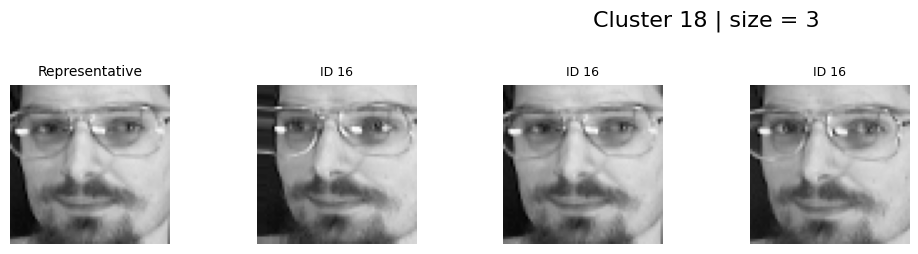

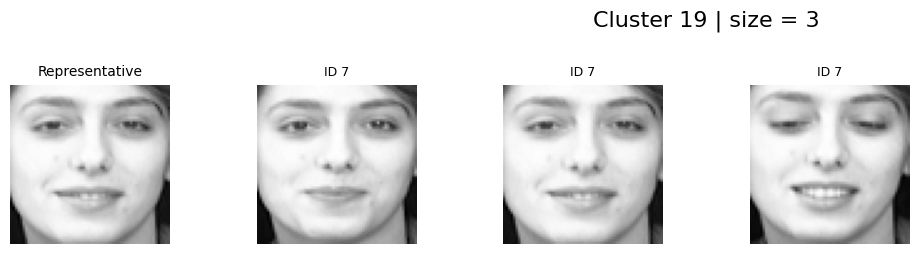

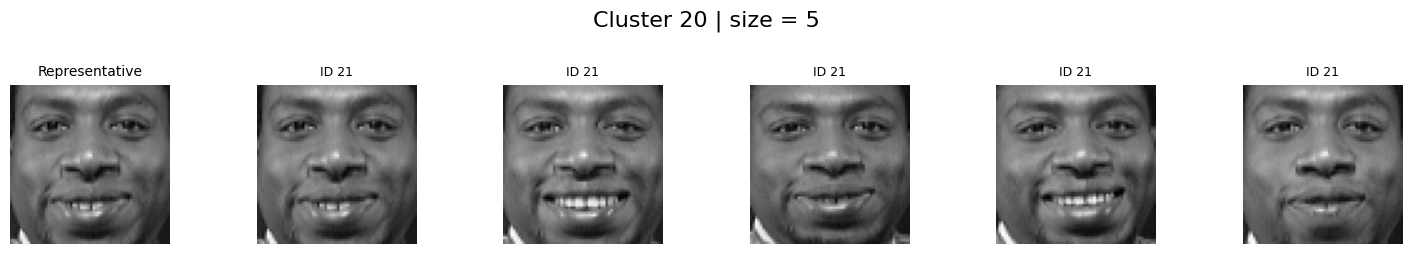

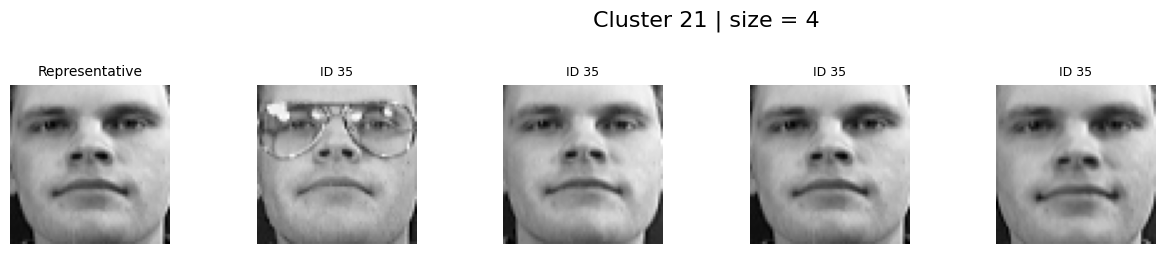

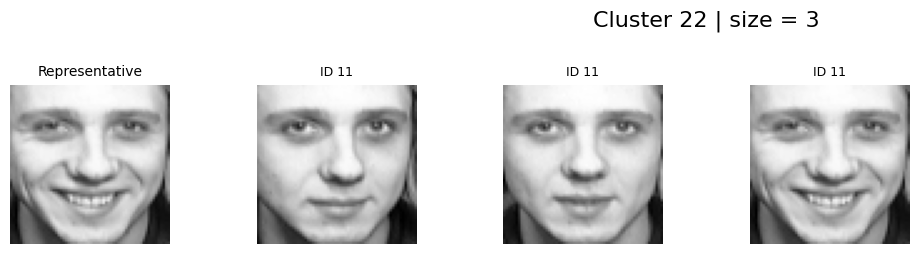

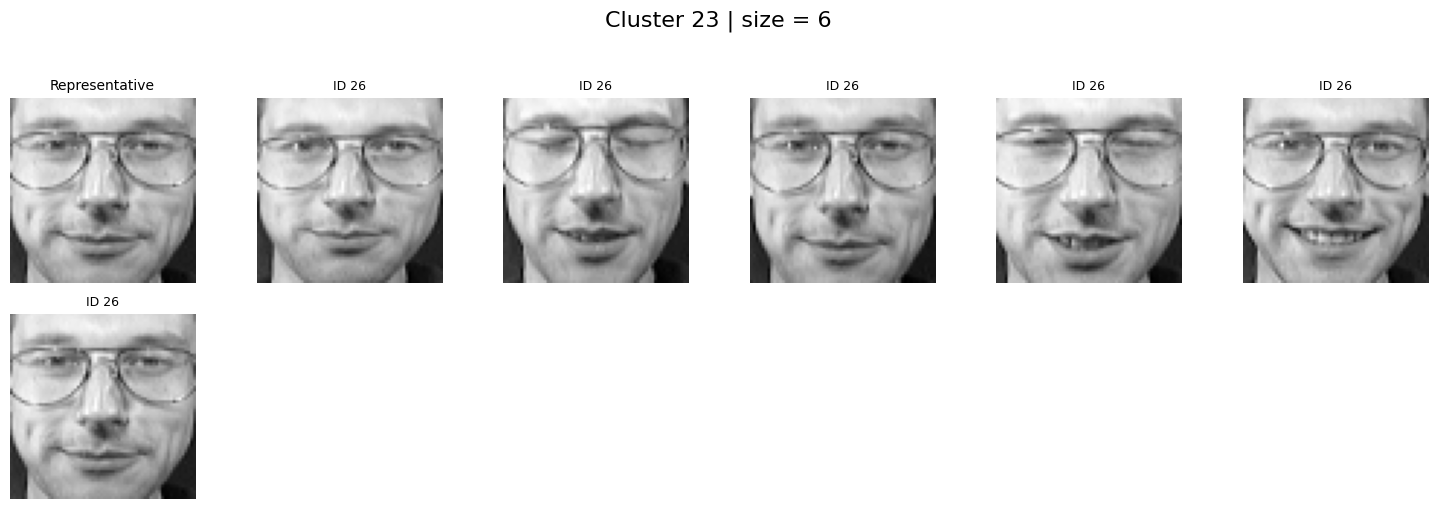

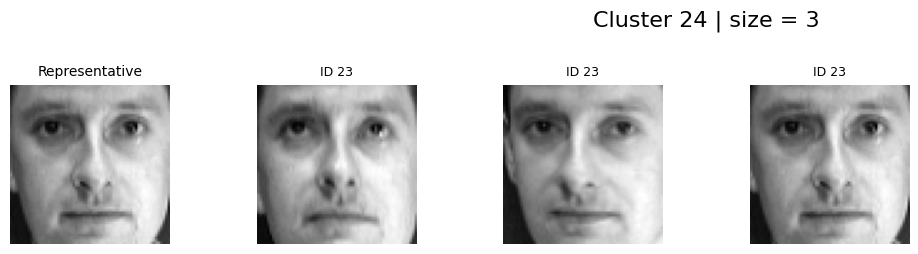

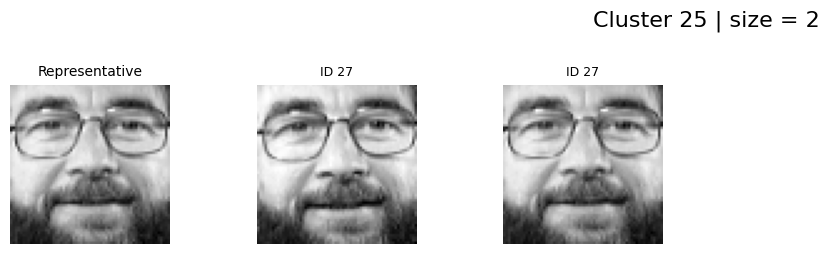

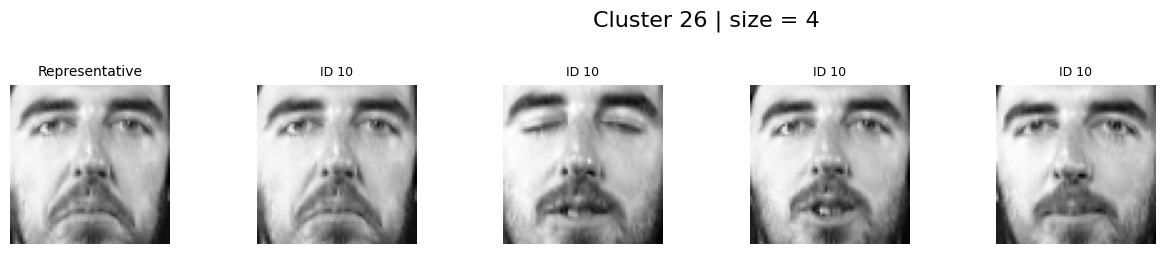

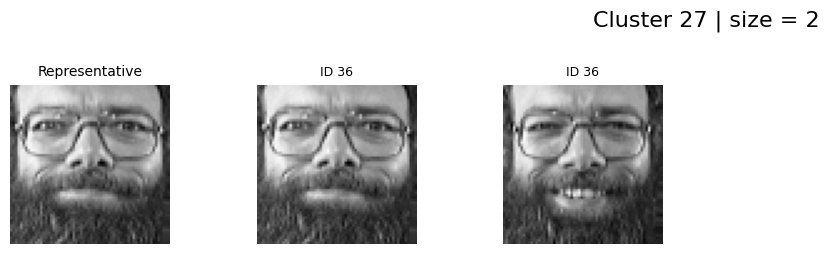

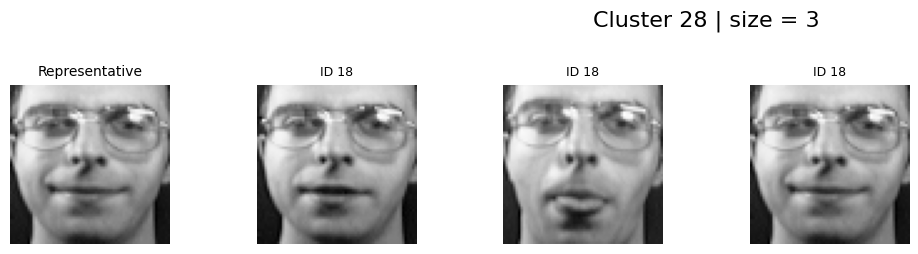

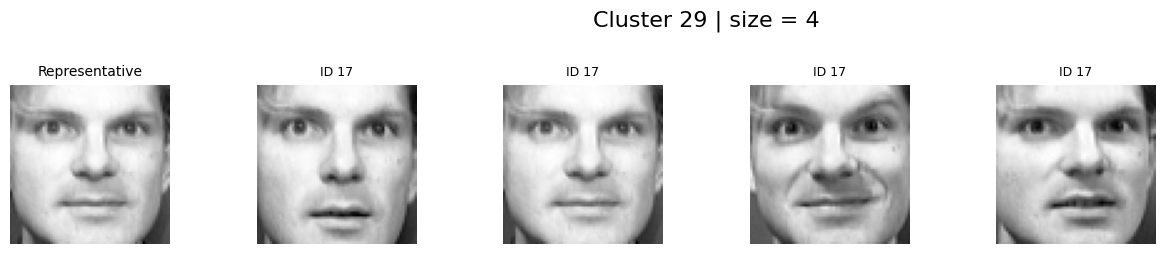

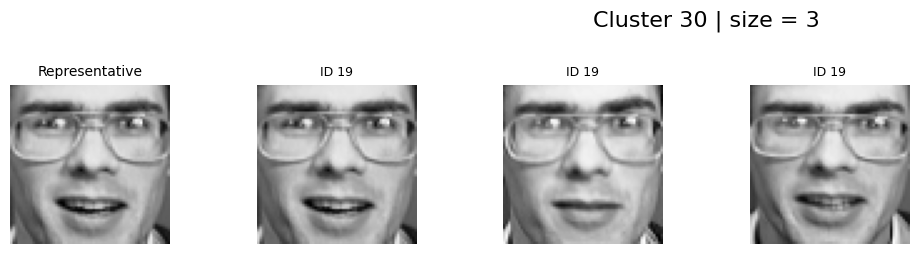

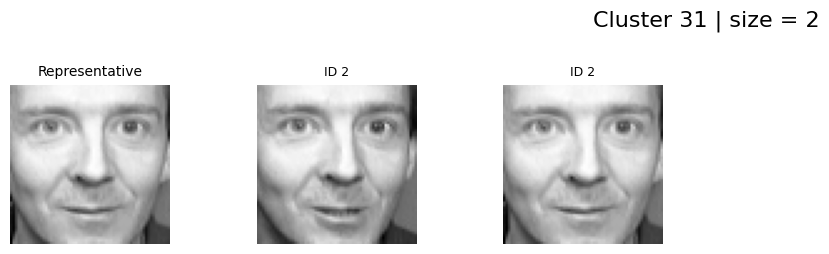

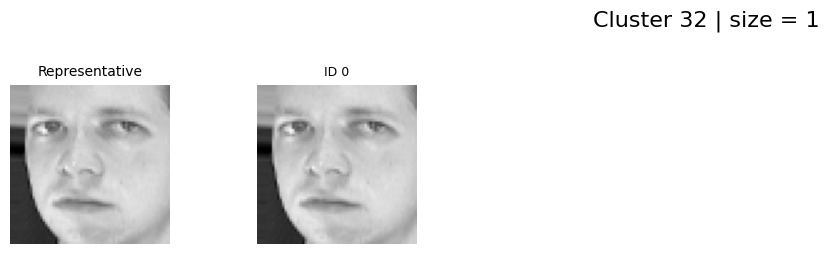

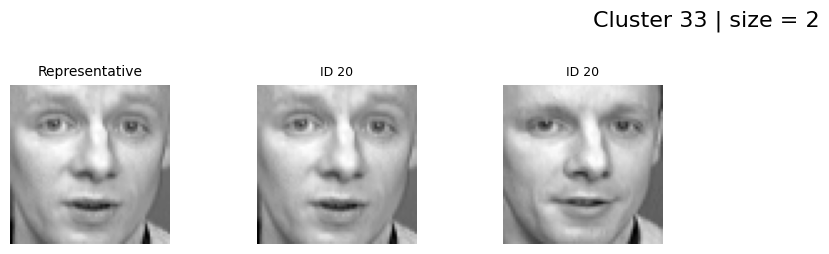

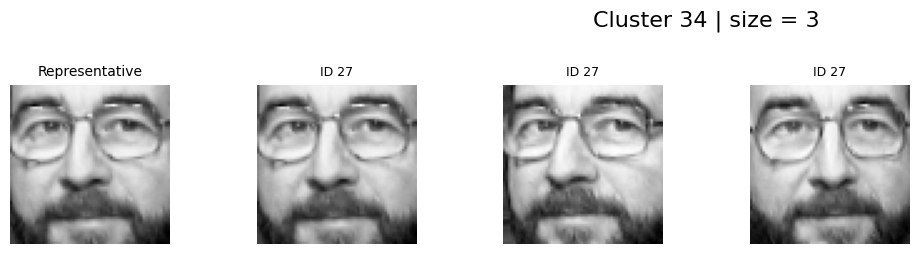

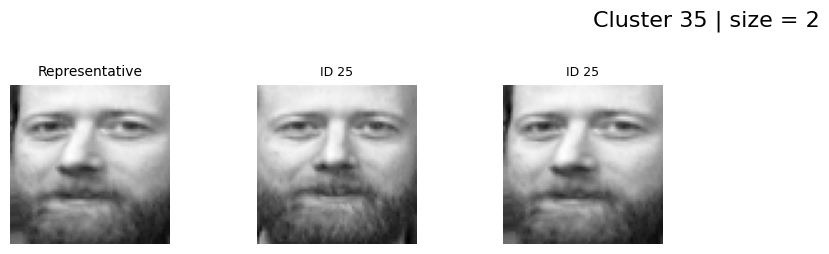

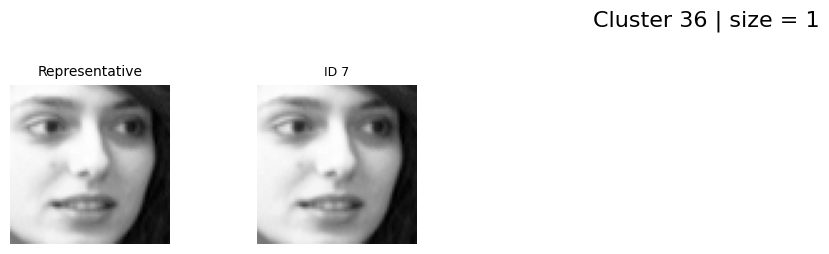

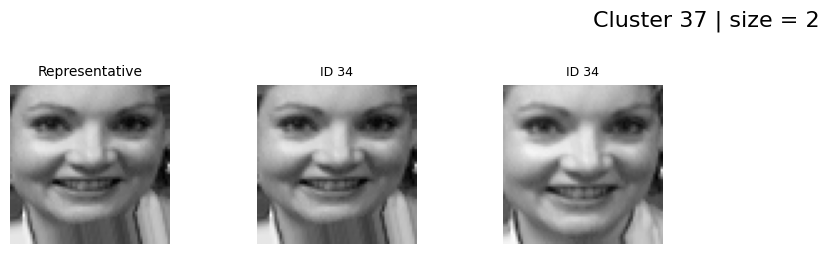

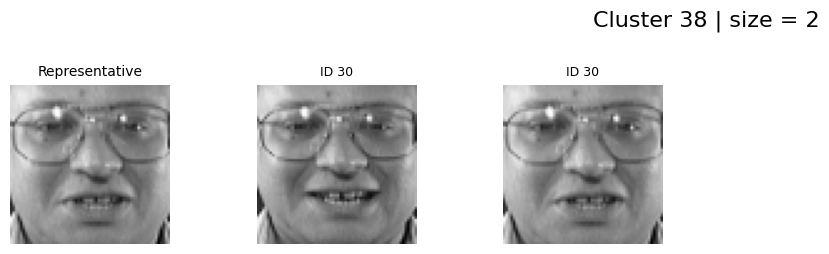

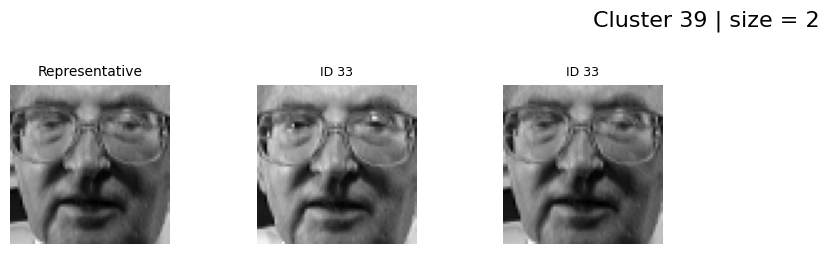

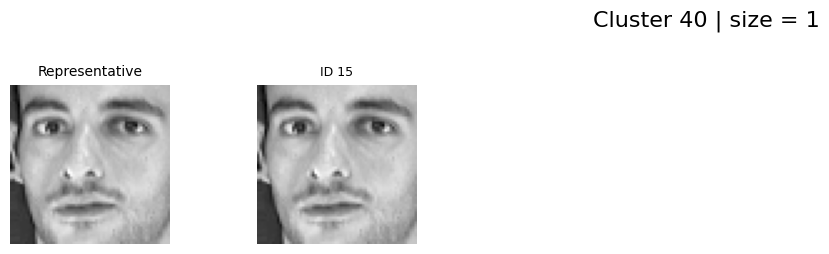

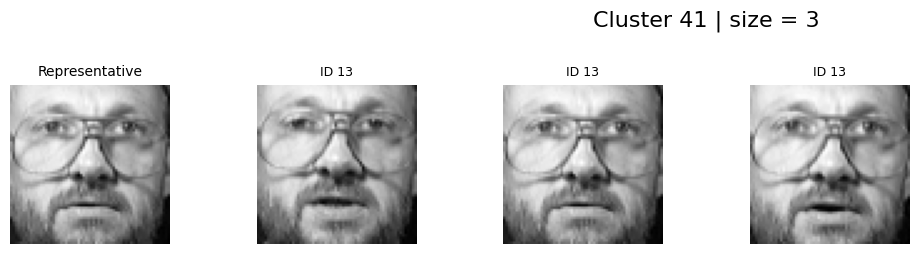

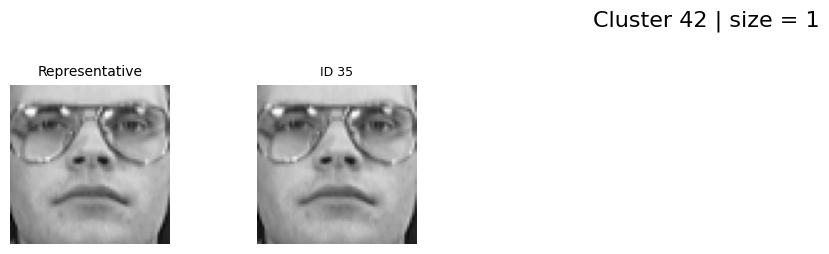

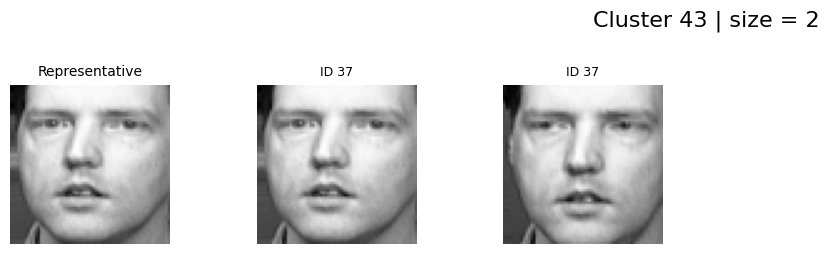

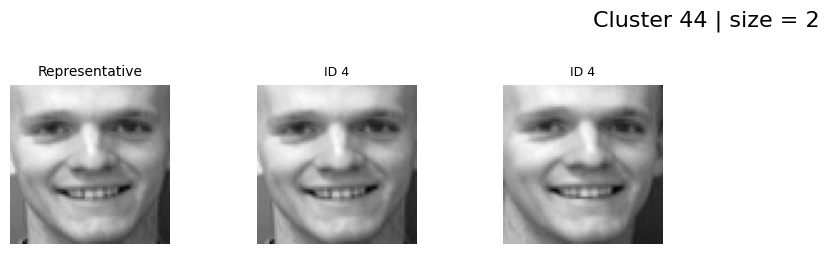

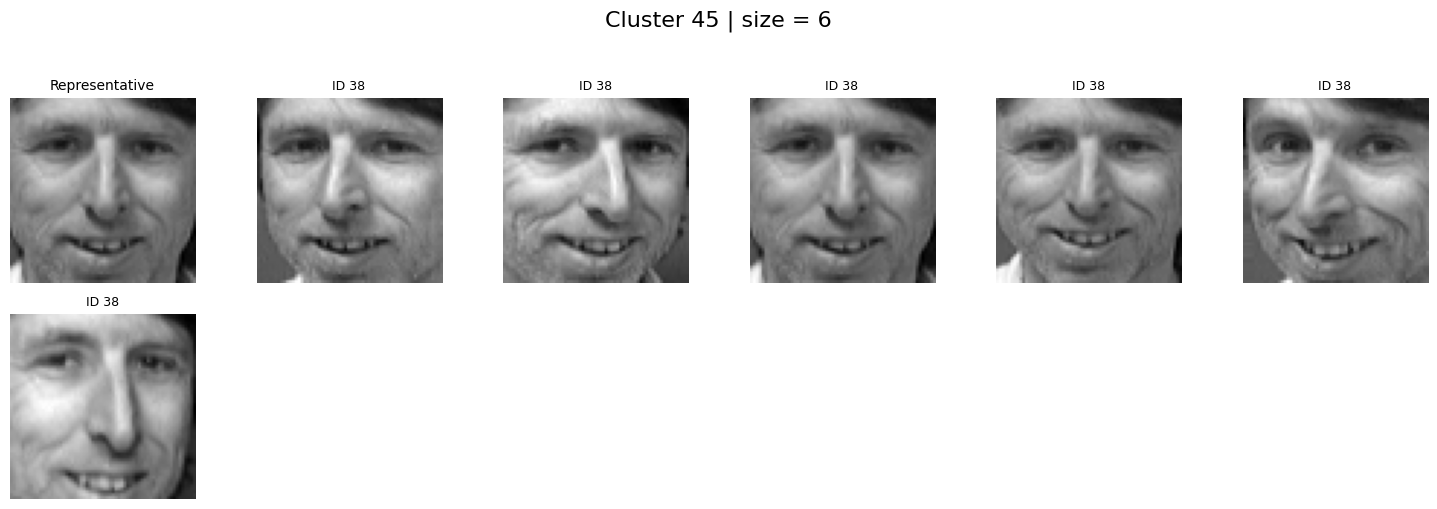

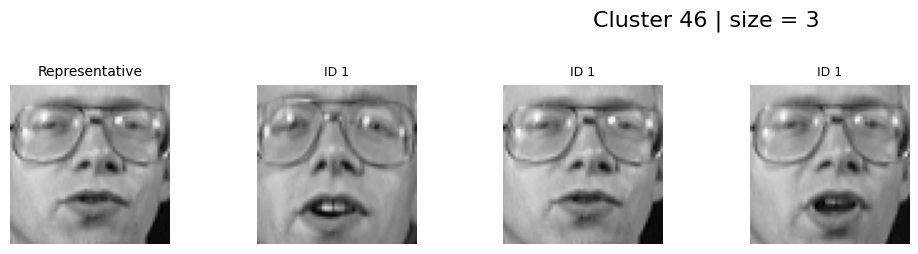

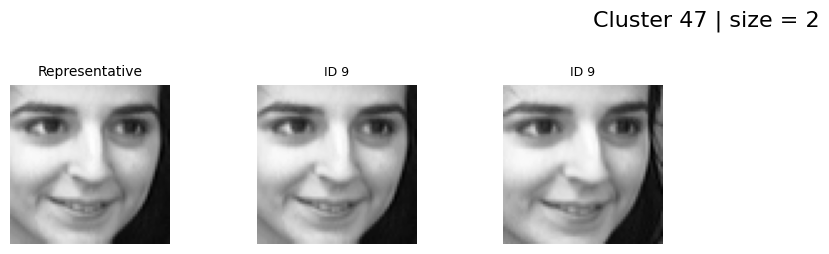

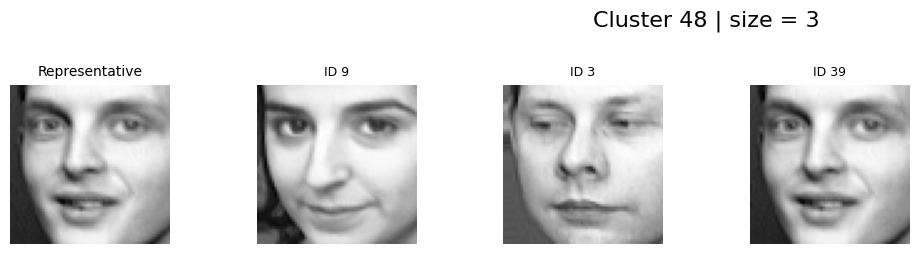

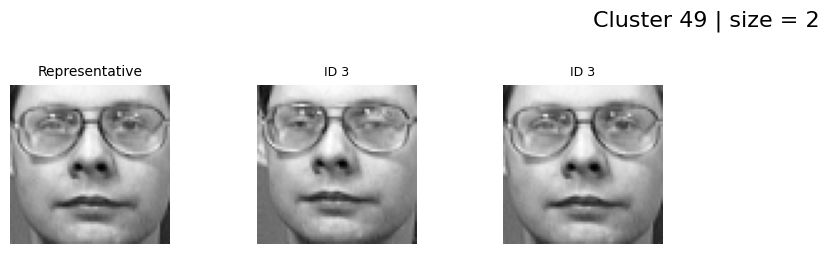

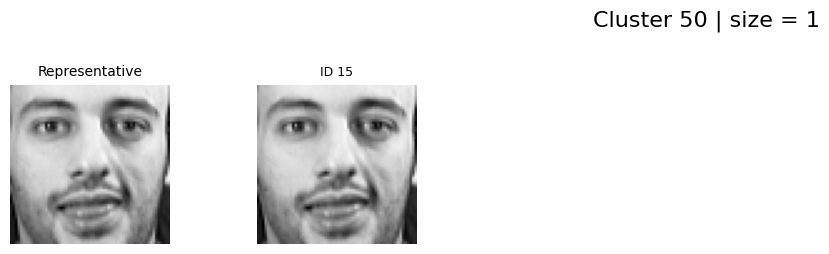

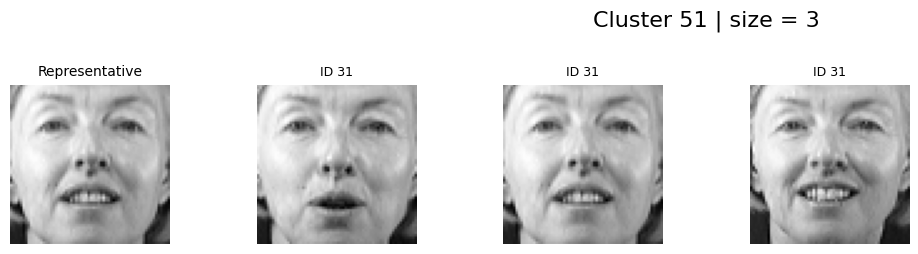

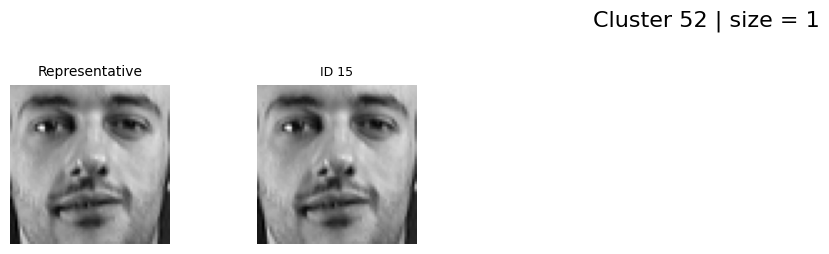

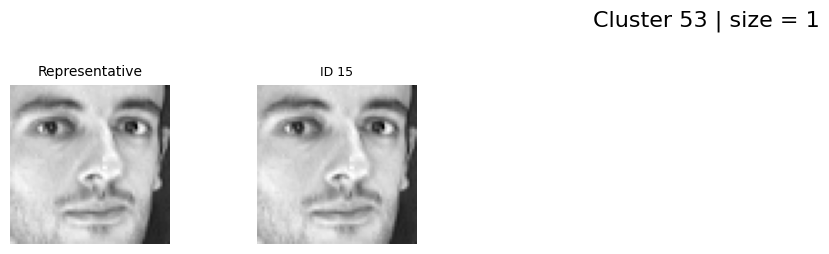

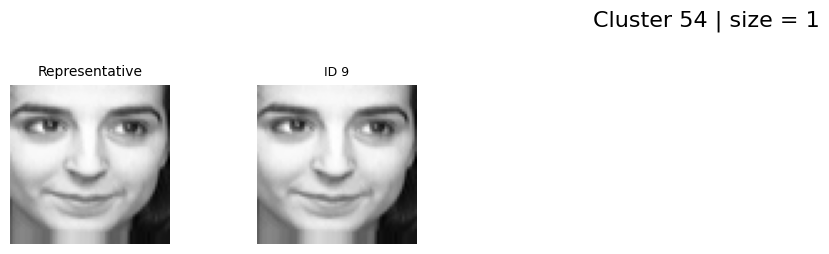

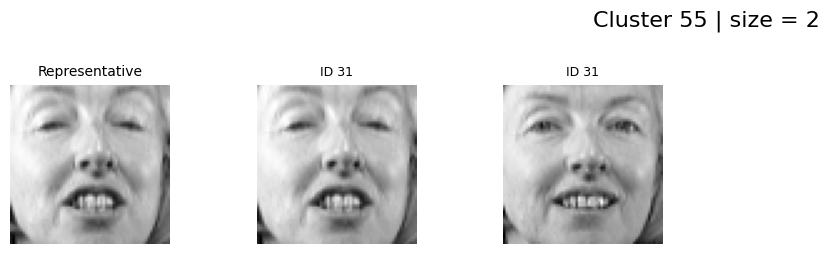

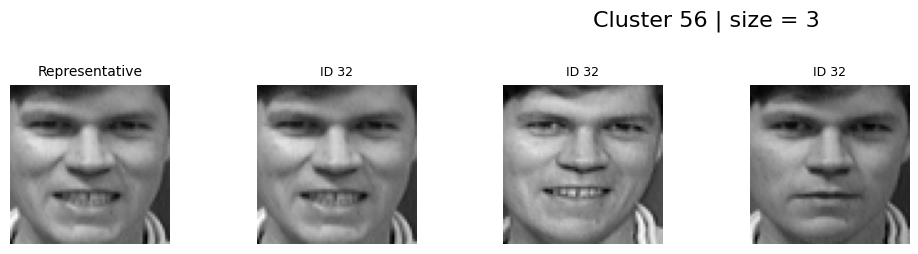

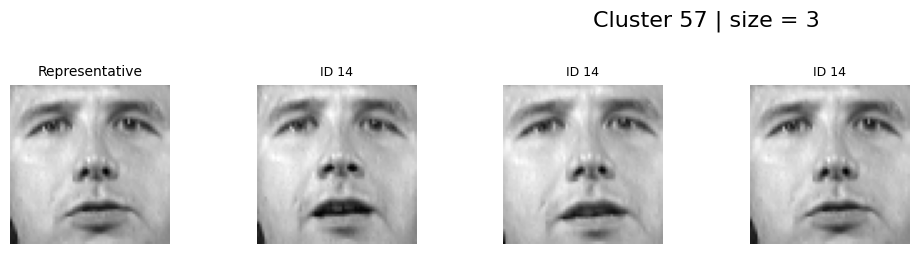

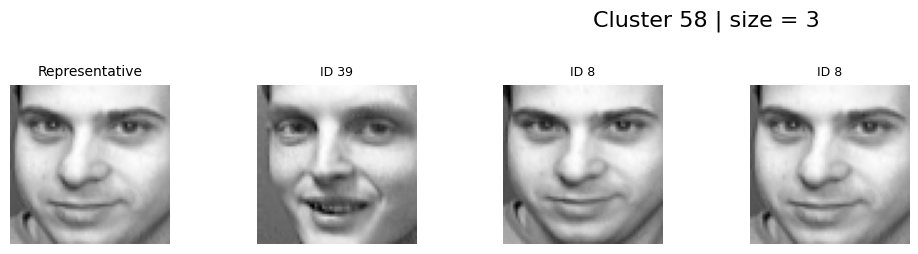

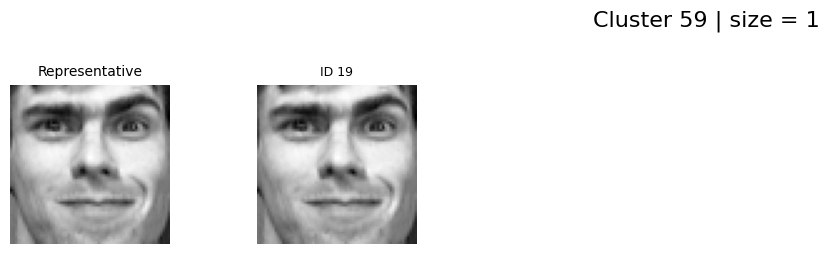

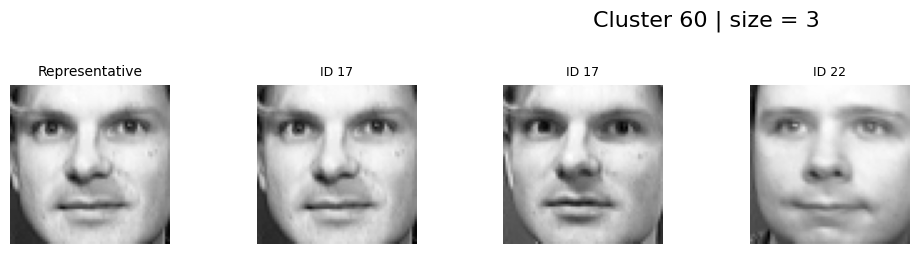

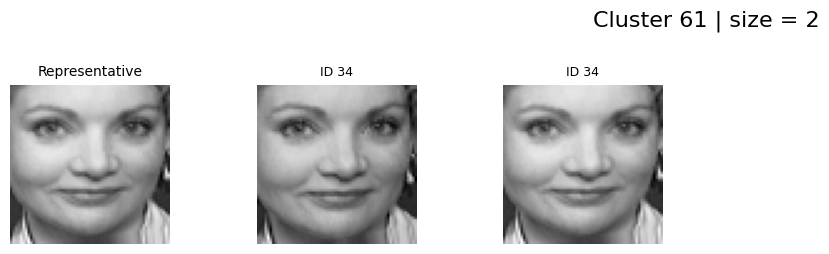

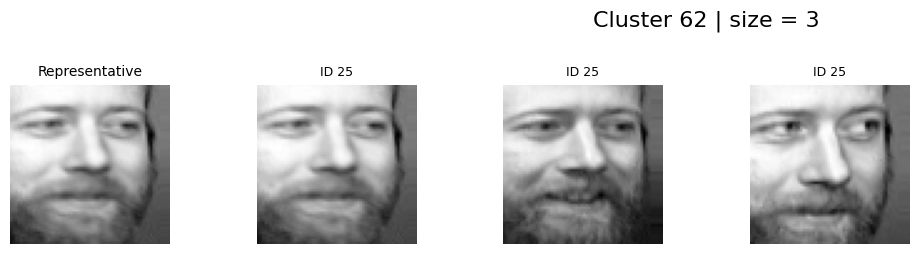

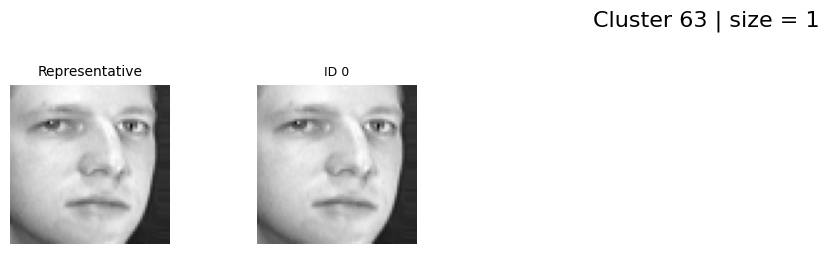

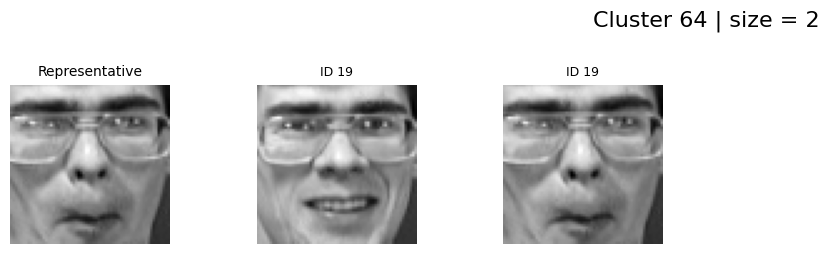

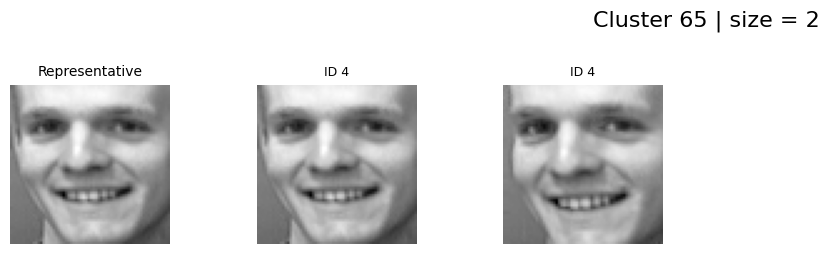

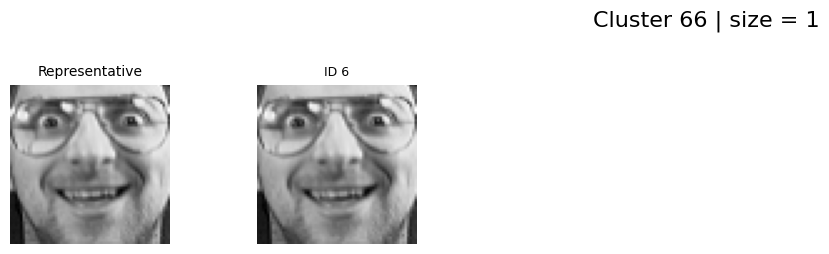

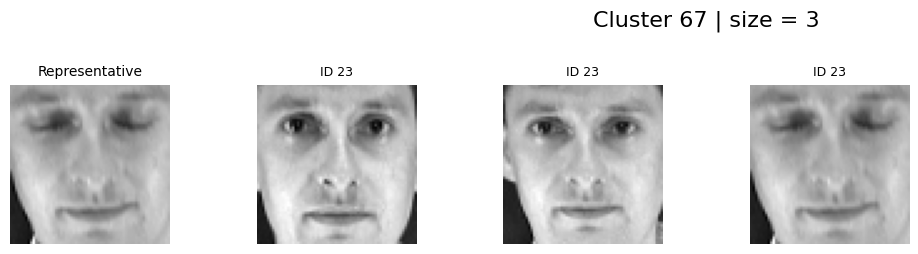

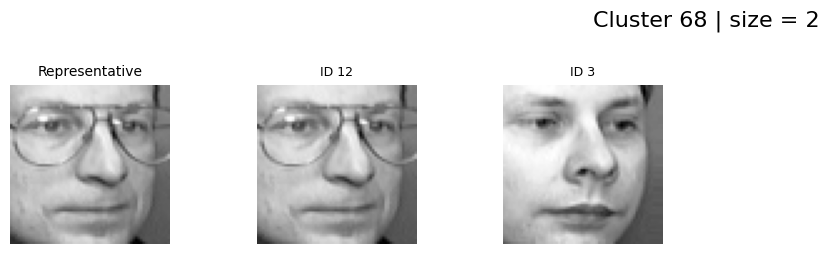

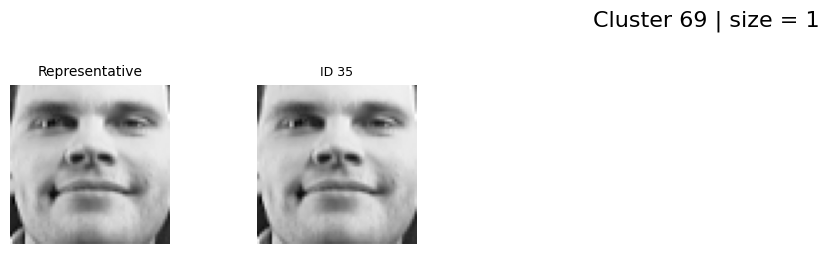

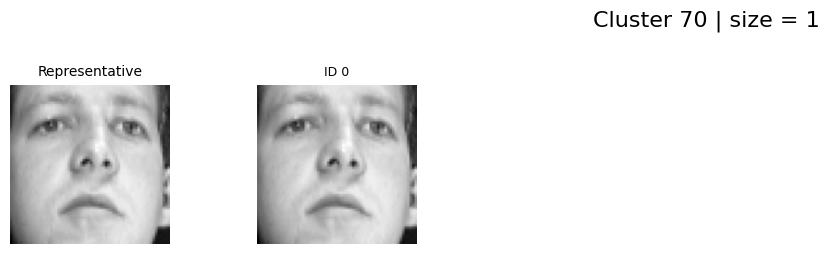

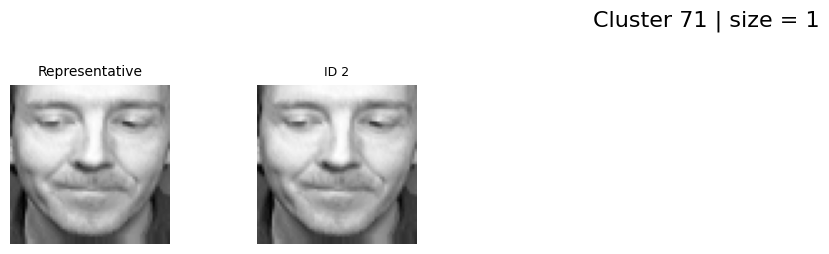

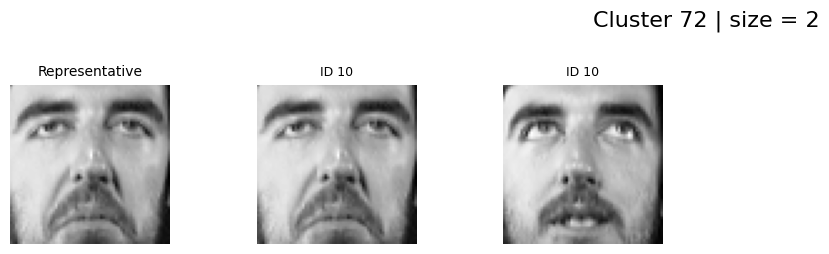

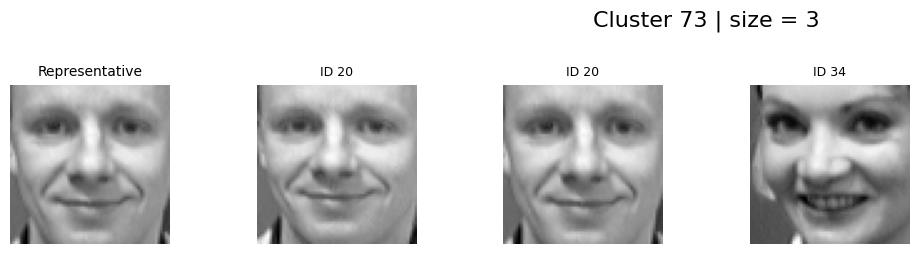

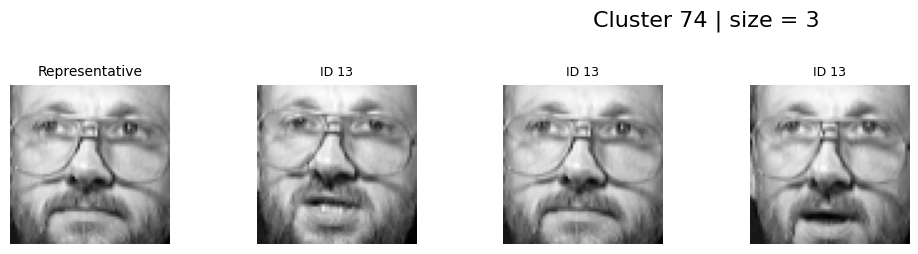

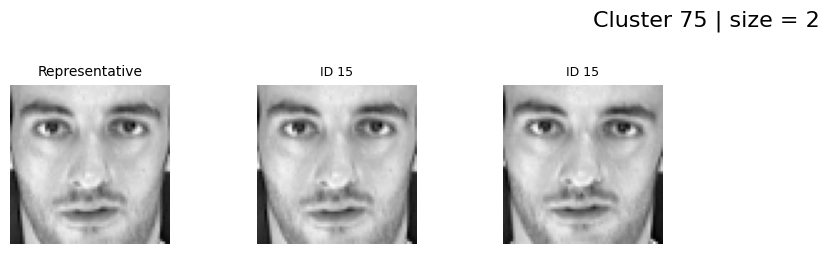

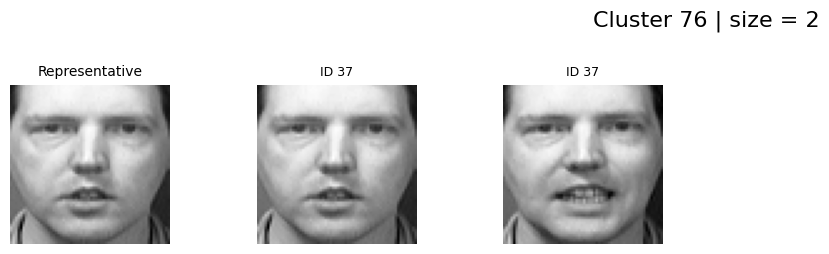

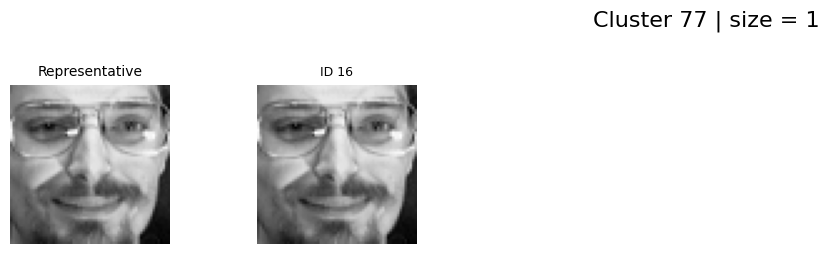

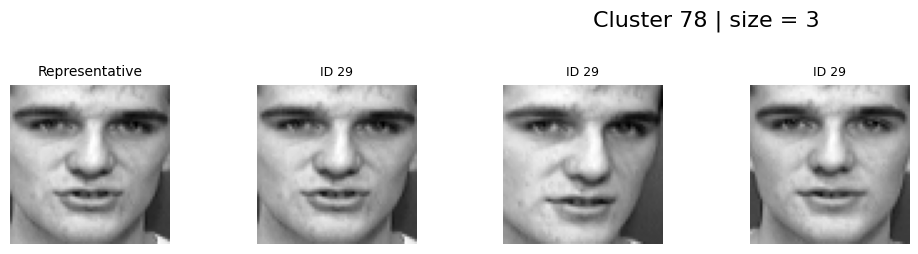

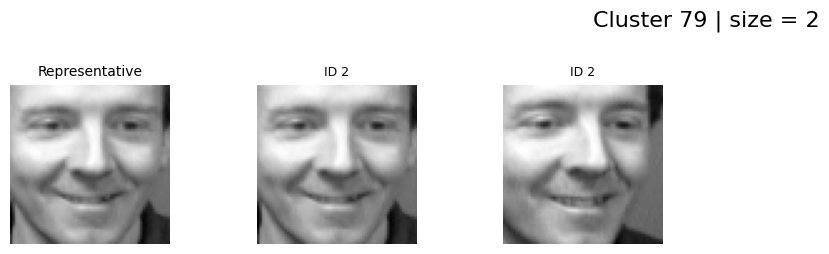

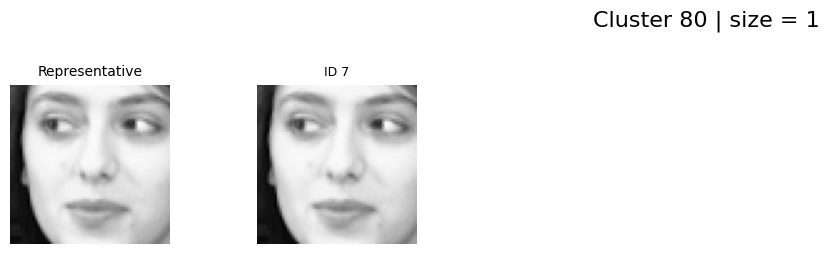

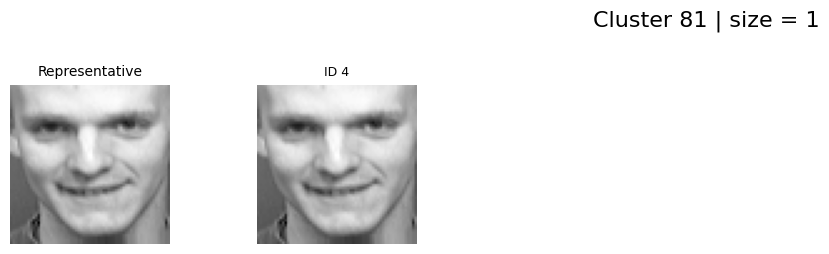

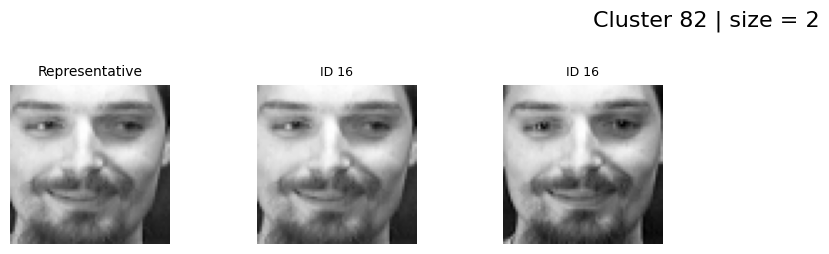

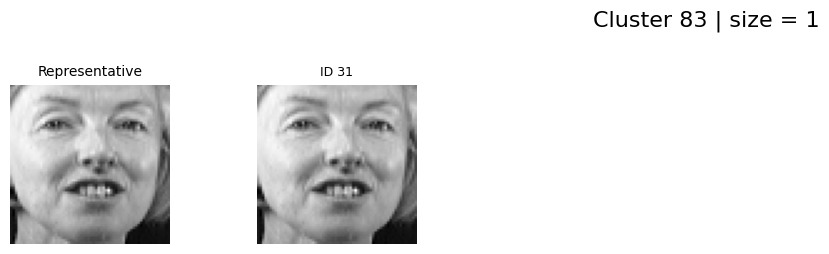

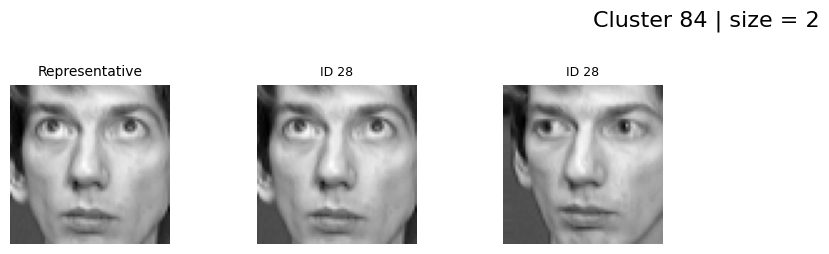

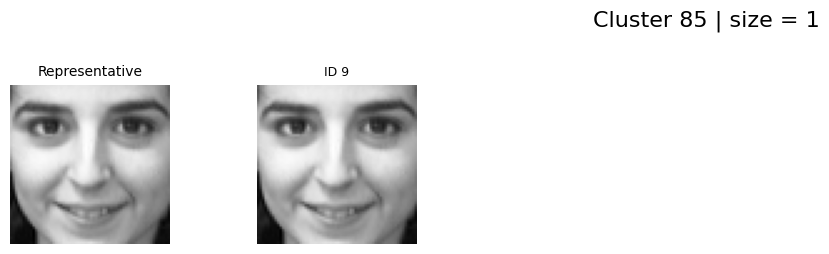

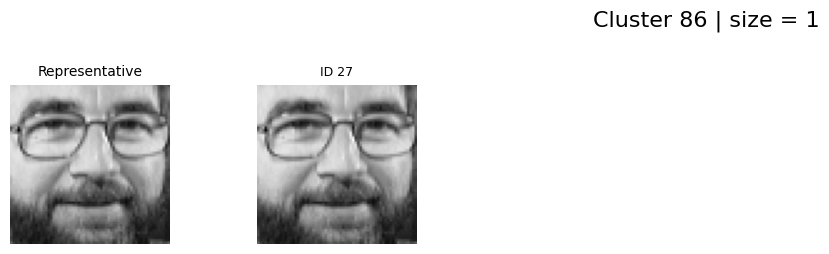

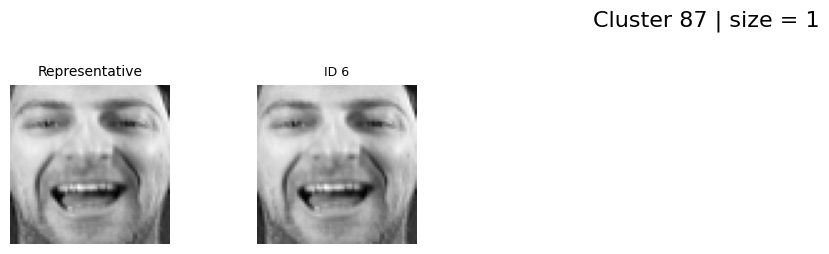

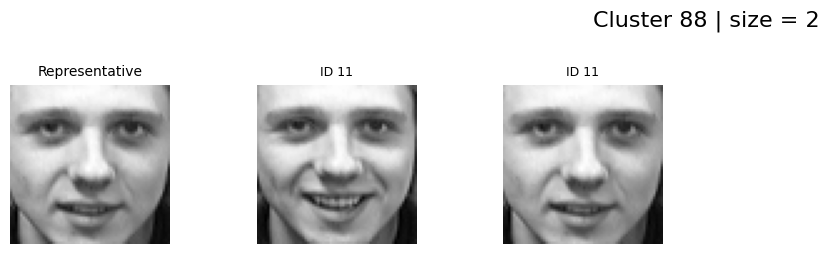

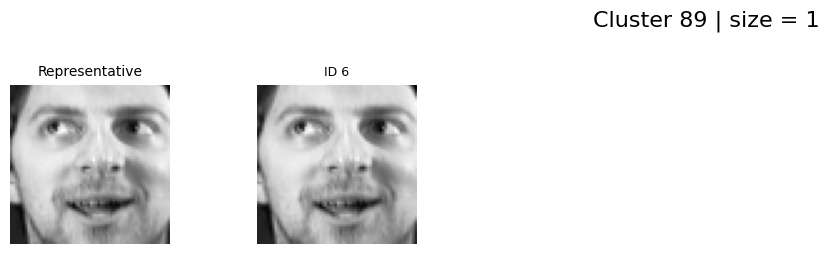

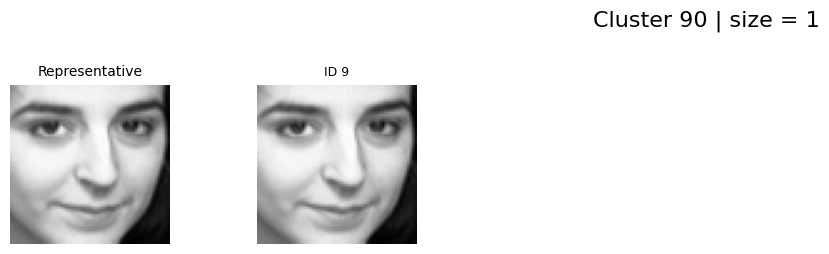

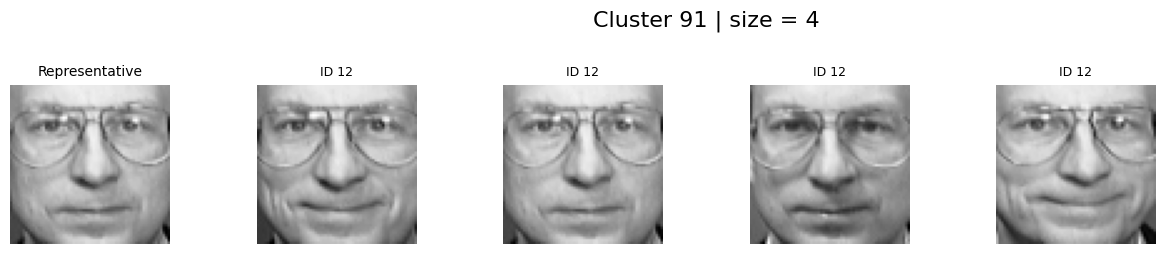

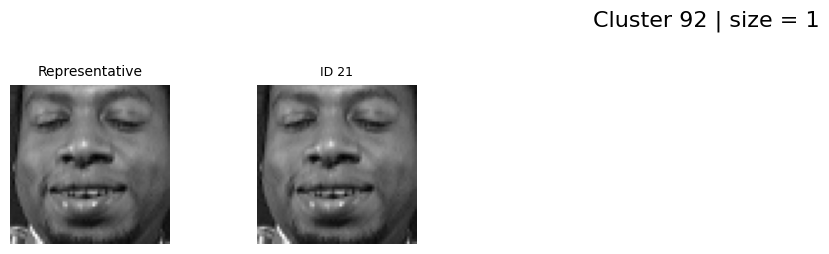

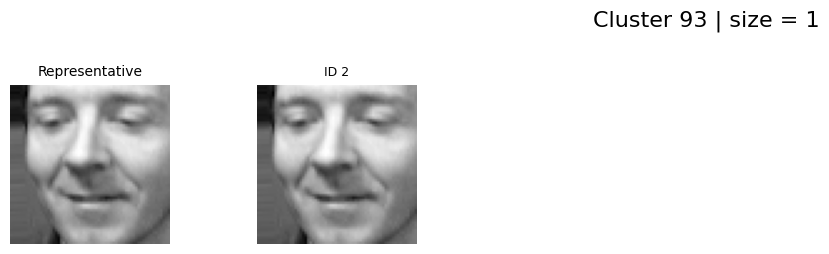

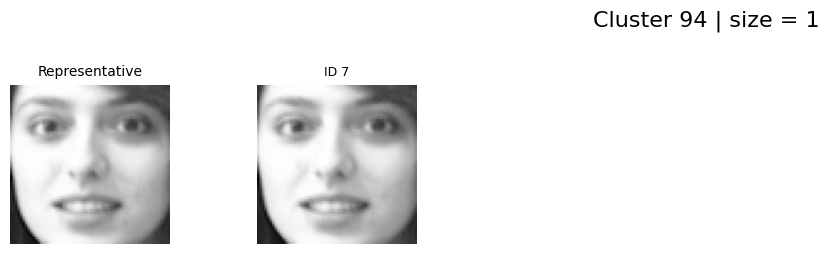

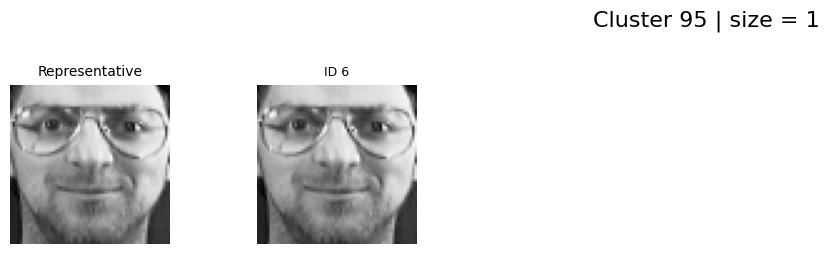

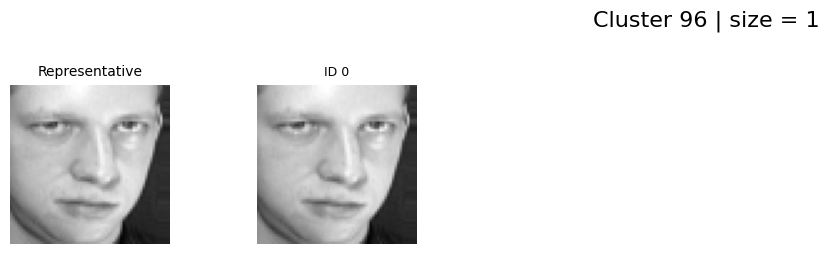

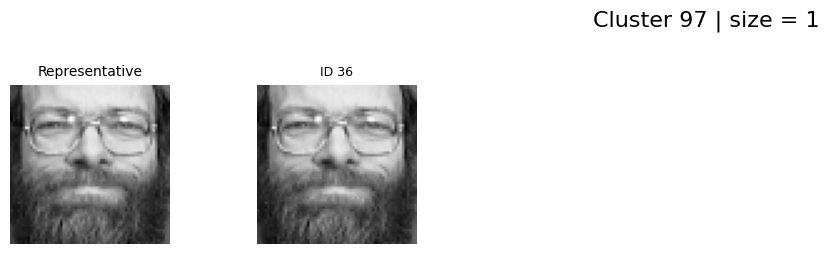

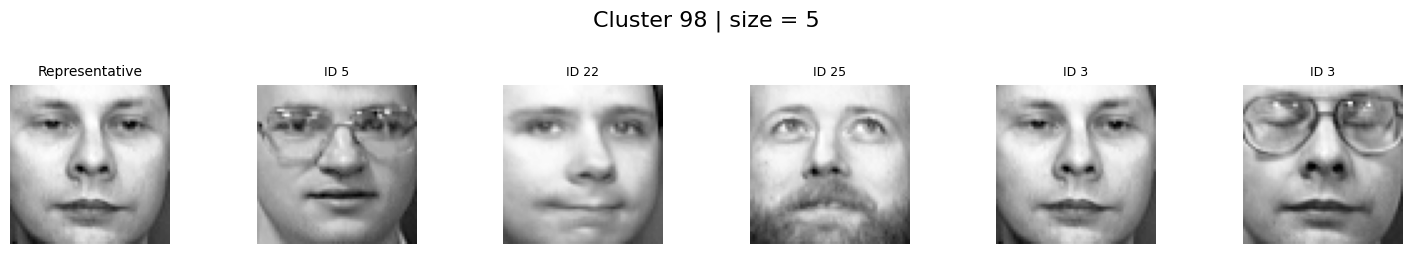

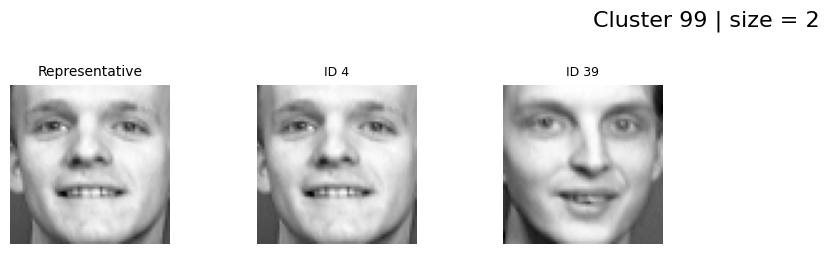

In [67]:
k = 100

kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
labels_train = kmeans.fit_predict(X_train)


# Distances from every training sample to every centroid: shape (n_samples, k)
X_train_dist = kmeans.transform(X_train)

# For each cluster (column), pick the sample (row) with the smallest distance
rep_idx = X_train_dist.argmin(axis=0)


EXAMPLES_PER_CLUSTER = 12   
N_COLS = 6                  # grid columns for examples
MAX_CLUSTERS_TO_SHOW = None 

cluster_ids = np.arange(k)
if MAX_CLUSTERS_TO_SHOW is not None:
    cluster_ids = cluster_ids[:MAX_CLUSTERS_TO_SHOW]

for cluster_id in cluster_ids:
    cluster_indices = np.where(labels_train == cluster_id)[0]
    cluster_size = len(cluster_indices)

    if cluster_size == 0:
        continue

    # Representative (closest to centroid)
    rep = rep_idx[cluster_id]

    # Sample example faces from this cluster
    n_show = min(cluster_size, EXAMPLES_PER_CLUSTER)
    sampled = np.random.choice(cluster_indices, size=n_show, replace=False)

    # Determine grid size: +1 for representative image
    total_images = 1 + n_show
    n_rows = int(np.ceil(total_images / N_COLS))

    plt.figure(figsize=(2.5 * N_COLS, 2.5 * n_rows))
    plt.suptitle(f"Cluster {cluster_id} | size = {cluster_size}", fontsize=16, y=1.02)

    # Plot representative face first
    plt.subplot(n_rows, N_COLS, 1)
    plt.imshow(images_train[rep], cmap="gray")
    plt.title("Representative", fontsize=10)
    plt.axis("off")

    # Plot example faces
    for i, idx in enumerate(sampled, start=2):
        plt.subplot(n_rows, N_COLS, i)
        plt.imshow(images_train[idx], cmap="gray")
        plt.title(f"ID {y_train[idx]}", fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()